In [1]:
import numpy as np

import rasterio
from rasterio.windows import Window

import fiona

from scripts.utils import trees_detection

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [87]:
IMAGE_PATH = '/Users/vasilii.mosin/Desktop/ForestHype/data/pp_2/pp_2_hsi_clipped.tif'
TREES_PATH = '/Users/vasilii.mosin/Desktop/ForestHype/data/pp_2/temp/detected_trees'

In [69]:
image = rasterio.open(IMAGE_PATH)

# Trees Detection

In [72]:
REF_BAND_NUM = 1 # band number for trees detection

In [86]:
reference_band = image.read(REF_BAND_NUM)

In [89]:
trees_detection(image, reference_band, TREES_PATH, smoothing=1, min_distance=10, exclude_border=28)

In [90]:
trees = fiona.open(TREES_PATH, 'r')

In [91]:
del reference_band

# Dataset

In [99]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from sklearn.model_selection import train_test_split

In [129]:
train_trees, valid_trees = train_test_split(list(trees), test_size=0.2)

In [92]:
class Dataset(BaseDataset):
    CROP_SIZE = 28
    BANDS = [1,3,8,13,16,19,27,32]
    
    def __init__(self, image, trees):
        self.trees = trees
        self.image = image
    
    def __getitem__(self, i):
        top = self.image.index(*self.trees[i]['geometry']['coordinates'])
        img = self.image.read(BANDS, window=Window(top[1]-CROP_SIZE//2,top[0]-CROP_SIZE//2,CROP_SIZE,CROP_SIZE))
        
        # return pair (img,img) since autoencoder
        return img, img
        
    def __len__(self):
        return len(self.trees)

In [130]:
train_dataset = Dataset(image, train_trees)
valid_dataset = Dataset(image, valid_trees)

<IPython.core.display.Javascript object>


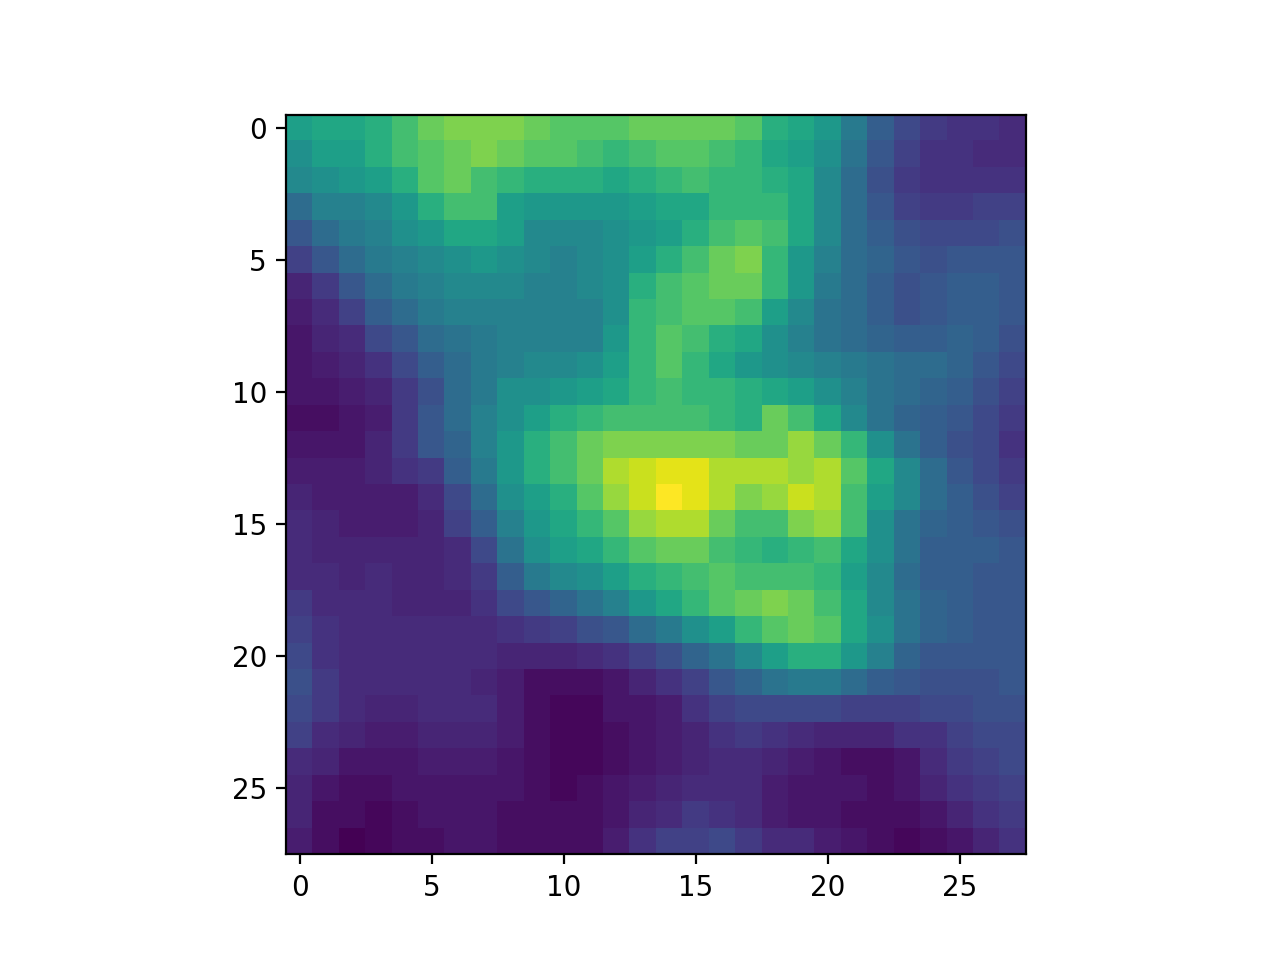

In [132]:
plt.imshow(train_dataset[4][0][0])
plt.show()

In [133]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)